In [22]:
from eda import get_objectives, get_constraints, non_dominated_sort, non_dominated
from eda import assign_crowding_distance, binary_tournament_selection
from eda import organize_results

In [23]:
from hdf5storage import loadmat, savemat
from numpy import random
import numpy as np
import pickle
from scipy.spatial.distance import jensenshannon

In [24]:
def sample_population(samples, distribution, pop_size, n_selected, capacity, p_rank,rng):
    """
        Sample population from distribution respecting capacity constraint.
        Human input(weights) is used to bias the sampling.
    """
    pop_count = 0
    population = np.zeros((pop_size, n_selected), dtype=np.int32)
    n_items = distribution.size

    distribution = distribution * p_rank
    distribution /= distribution.sum()

    while pop_count < pop_size:
        knapsack = rng.choice(n_items, n_selected, p=distribution, replace=False)
        constraint = np.sum(samples[knapsack, -1])
        if constraint <= capacity:
            population[pop_count, :] = knapsack
            pop_count += 1

    return population

In [25]:
class KnapsackEDA:
    """
    Estimation of Distribution Algorithm for Multi-Objective Knapsack Problem.
    
    Encapsulates the EDA algorithm with state management for distribution,
    population, and objectives across generations.
    """
    
    def __init__(self, items, capacity, p_rank,
                 n_selected, n_obj, 
                 pop_size=1000, generations=100, max_no_improve_gen=20, seed=1123):
        """
        Initialize EDA algorithm.
        
        Parameters:
        -----------
        items : np.ndarray
            Array of items with shape (n_items, n_obj + n_con)
        capacity : float
            Capacity constraint
        n_selected : int
            Number of items to select per solution
        n_obj : int
            Number of objectives
        pop_size : int
            Population size
        generations : int
            Number of generations to run
        seed : int
            Random seed
        """
        self.items = items
        self.capacity = capacity
        self.p_rank = p_rank
        self.n_selected = n_selected
        self.n_obj = n_obj
        self.pop_size = pop_size
        self.generations = generations
        self.max_no_improve_gen = max_no_improve_gen
        self.rng = random.default_rng(seed=seed)
        
        # State variables (will be initialized during run)
        self.distribution = None
        self.selected_population = None
        self.selected_objectives = None
        
        # Results storage
        self.distribution_table = []
        self.pareto_indices_table = []
        self.pareto_front_table = []
        self.js_div_list = []
        self.converged_pf_table = []
    

    def _generate_initial_population(self):
        """Generate initial population based on tournament selection."""
        n_items = self.items.shape[0]
        distribution = np.ones(n_items) / n_items
        population = sample_population(
            self.items, distribution, self.pop_size, self.n_selected, 
            self.capacity, self.p_rank, self.rng
        )
        objectives = get_objectives(self.items, population, self.n_obj)
        
        # _, _, ranks, fronts = non_dominated_sort(objectives)
        ranks, fronts = non_dominated_sort(objectives)
        distances_all_solutions = np.zeros(population.shape[0], dtype=float)
        for f in fronts:
            distances = assign_crowding_distance(objectives[f, :])
            distances_all_solutions[f] = distances
        
        select_indices = np.array([], dtype=int)
        while len(select_indices) < self.pop_size:
            indice = binary_tournament_selection(
                population, ranks, distances_all_solutions, self.rng
            )
            select_indices = np.concatenate([select_indices, np.array([indice])])
        
        selected_population = population[select_indices]
        selected_objectives = objectives[select_indices]
        
        distribution = np.ones(n_items)
        distribution += np.bincount(selected_population.flatten(), minlength=n_items)
        distribution /= np.sum(distribution)
        
        return distribution, selected_population, selected_objectives
    
    def _update_distribution(self):
        """Update distribution and select new population."""
        population = sample_population(
            self.items, self.distribution, self.pop_size, self.n_selected,
            self.capacity, self.p_rank, self.rng
        )
        objectives = get_objectives(self.items, population, self.n_obj)
        
        # Find current pareto front
        # _, _, _, fronts_current = non_dominated_sort(objectives)
        _, fronts_current = non_dominated_sort(objectives)
        pareto_indices = population[fronts_current[0]]
        
        objectives = np.vstack((self.selected_objectives, objectives))
        population = np.vstack((self.selected_population, population))
        
        # _, _, ranks, fronts = non_dominated_sort(objectives)
        ranks, fronts = non_dominated_sort(objectives)
        select_indices = np.array([], dtype=np.int32)
        for f in fronts:
            if len(select_indices) + len(f) <= self.pop_size:
                select_indices = np.concatenate([select_indices, f])
            else:
                remaining_size = self.pop_size - len(select_indices)
                f_distance = assign_crowding_distance(objectives[f, :])
                sort_indices = np.argsort(f_distance)[::-1]
                remaining = f[sort_indices[:remaining_size]]
                select_indices = np.concatenate([select_indices, remaining])
                break
        
        selected_population = population[select_indices]
        selected_objectives = objectives[select_indices]
        
        n_items = self.items.shape[0]
        updated_distribution = np.ones(n_items)
        updated_distribution += np.bincount(selected_population.flatten(), minlength=n_items)
        updated_distribution /= np.sum(updated_distribution)
        
        self.distribution[self.distribution < 1E-08] = 1E-08
        updated_distribution[updated_distribution < 1E-08] = 1E-08
        js_div = jensenshannon(self.distribution, updated_distribution)**2
        
        return updated_distribution, selected_population, selected_objectives, pareto_indices, js_div
    
    def _converged_pf(self):
        """Find the converged Pareto Front using non-dominated, still updating distribution."""
        population = sample_population(
            self.items, self.distribution, self.pop_size, self.n_selected,
            self.capacity, self.p_rank, self.rng
        )
        objectives = get_objectives(self.items, population, self.n_obj)

        # find current pareto front
        pareto_indices = population[non_dominated(objectives).astype(bool)]

        population = np.unique(np.sort(np.vstack((self.selected_population, population)), axis=1), axis=0)
        objectives = get_objectives(self.items, population, self.n_obj)

        nd_idx = non_dominated(objectives).astype(bool)
        selected_population = population[nd_idx]
        selected_objectives = objectives[nd_idx]

        n_items = self.items.shape[0]
        updated_distribution = np.ones(n_items)
        updated_distribution += np.bincount(selected_population.flatten(), minlength=n_items)
        updated_distribution /= np.sum(updated_distribution)
        
        self.distribution[self.distribution < 1E-08] = 1E-08
        updated_distribution[updated_distribution < 1E-08] = 1E-08
        js_div = jensenshannon(self.distribution, updated_distribution)**2

        return updated_distribution, selected_population, selected_objectives, pareto_indices, js_div
        
    
    def run(self):
        """
        Run the EDA algorithm for specified number of generations.
        
        Returns:
        --------
        dict : Dictionary containing results
            - distribution_table : List of distributions per generation
            - pareto_indices_table : List of pareto indices per generation
            - pareto_front_table : List of pareto fronts per generation
            - js_div_list : Jensen-Shannon divergence per generation
        """
        # Initialize
        self.distribution, self.selected_population, self.selected_objectives = \
            self._generate_initial_population()
        

        # Mode 1: run until distribution converges
        no_improve_gen = 0
        prev_js_div = None
        generation = 0
        while no_improve_gen < self.max_no_improve_gen:
            generation += 1
            print(f"Mode 1 generation {generation} (no improve count: {no_improve_gen})")
            self.distribution, self.selected_population, self.selected_objectives, \
                pareto_indices, js_div = self._update_distribution()
            # print(f"number of front 0: {pareto_indices.shape[0]}")

            pareto_front = np.zeros((pareto_indices.shape[0], self.items.shape[1]))
            for k in range(pareto_indices.shape[0]):
                pareto_front[k, :] = np.sum(self.items[pareto_indices[k, :], :], axis=0)
                
            self.distribution_table.append(self.distribution.copy())
            self.pareto_indices_table.append(pareto_indices.copy())
            self.pareto_front_table.append(pareto_front.copy())
            self.js_div_list.append(js_div)
                
            if prev_js_div is not None:
                diff = prev_js_div - js_div
                if np.abs(diff) > 0.0001:
                    no_improve_gen = 0
                else:
                    no_improve_gen += 1
            else:
                no_improve_gen = 0
            prev_js_div = js_div
        
        # Mode 2: run until Pareto Front converges
        no_improve_gen = 0
        counter = 0 
        prev_front_0 = None
        while no_improve_gen < 2: ## loosen criteria
            counter += 1
            print(f"Mode 2 generation {counter} (no improve count: {no_improve_gen})")
            self.distribution, self.selected_population, self.selected_objectives, \
                pareto_indices, js_div = self._converged_pf()
            # print(f"number of front 0: {pareto_indices.shape[0]}")

            pareto_front = np.zeros((pareto_indices.shape[0], self.items.shape[1]))
            for k in range(pareto_indices.shape[0]):
                pareto_front[k, :] = np.sum(self.items[pareto_indices[k, :], :], axis=0)
            
            self.distribution_table.append(self.distribution.copy())
            self.pareto_indices_table.append(pareto_indices.copy())
            self.pareto_front_table.append(pareto_front.copy())
            self.js_div_list.append(js_div)

            front_0 = np.unique(self.selected_objectives, axis=0)
            front_0 = front_0[np.lexsort(front_0.T[::-1])]
            if prev_front_0 is not None:
                if np.array_equal(prev_front_0, front_0):
                    no_improve_gen += 1
                else:
                    no_improve_gen = 0
            else:
                no_improve_gen = 0
            
            self.converged_pf_table.append(front_0.copy())
            prev_front_0 = front_0

        return {
            'pareto_indices_table': self.pareto_indices_table,
            'pareto_front_table': self.pareto_front_table,
            'js_div_list': self.js_div_list,
            'converged_pf_table': self.converged_pf_table,
            'mode 1 generations': generation,
            'mode 2 generations': counter
        }

In [26]:
kn = loadmat('/data/knapsack/runA/kn_2_3_allneg_120_12_3.mat')
items = kn['items'][0]
capacity = kn['capacity']
n_selected = kn['n_selected']
n_obj = kn['n_obj']
pop_size = 1_000
generations = 100 
max_no_improve_gen = 5
eda_seed = 1223

In [27]:
# human input
aspi_item = np.array([3, 14, 3])
item_scores = items[:, :n_obj] @ aspi_item
r = item_scores.argsort().argsort().astype(float)
s = r / (r.max() + 1e-12)
logits = s / 0.1
logits -= logits.max() 
p_rank = np.exp(logits)
p_rank /= p_rank.sum()

In [28]:
eda = KnapsackEDA(
        items=items,
        capacity=capacity,
        p_rank=p_rank,
        n_selected=n_selected,
        n_obj=n_obj,
        pop_size=pop_size,
        generations=generations,
        max_no_improve_gen=max_no_improve_gen,
        seed=1123
    )
results = eda.run()

Mode 1 generation 1 (no improve count: 0)
Mode 1 generation 2 (no improve count: 0)
Mode 1 generation 3 (no improve count: 0)
Mode 1 generation 4 (no improve count: 0)
Mode 1 generation 5 (no improve count: 0)
Mode 1 generation 6 (no improve count: 0)
Mode 1 generation 7 (no improve count: 0)
Mode 1 generation 8 (no improve count: 0)
Mode 1 generation 9 (no improve count: 0)
Mode 1 generation 10 (no improve count: 1)
Mode 1 generation 11 (no improve count: 2)
Mode 1 generation 12 (no improve count: 3)
Mode 1 generation 13 (no improve count: 4)
Mode 2 generation 1 (no improve count: 0)
Mode 2 generation 2 (no improve count: 0)
Mode 2 generation 3 (no improve count: 0)
Mode 2 generation 4 (no improve count: 0)
Mode 2 generation 5 (no improve count: 0)
Mode 2 generation 6 (no improve count: 0)
Mode 2 generation 7 (no improve count: 0)
Mode 2 generation 8 (no improve count: 0)
Mode 2 generation 9 (no improve count: 0)
Mode 2 generation 10 (no improve count: 0)
Mode 2 generation 11 (no impr

In [29]:
# js_div_list, distribution_table, pareto_indices_table, pareto_front_table = organize_results(results) 
# final_results = {
#     'js_div_list': js_div_list,
#     'distribution_table': distribution_table,
#     'pareto_indices_table': pareto_indices_table,
#     'pareto_front_table': pareto_front_table
# } 

In [30]:
with open('eda_softmax_120_12_3.pkl', 'wb') as f:
    pickle.dump(results, f)

In [31]:
pareto_front = kn['pareto_front_final'][0]
pareto_front_softmax = results['converged_pf_table'][-1]

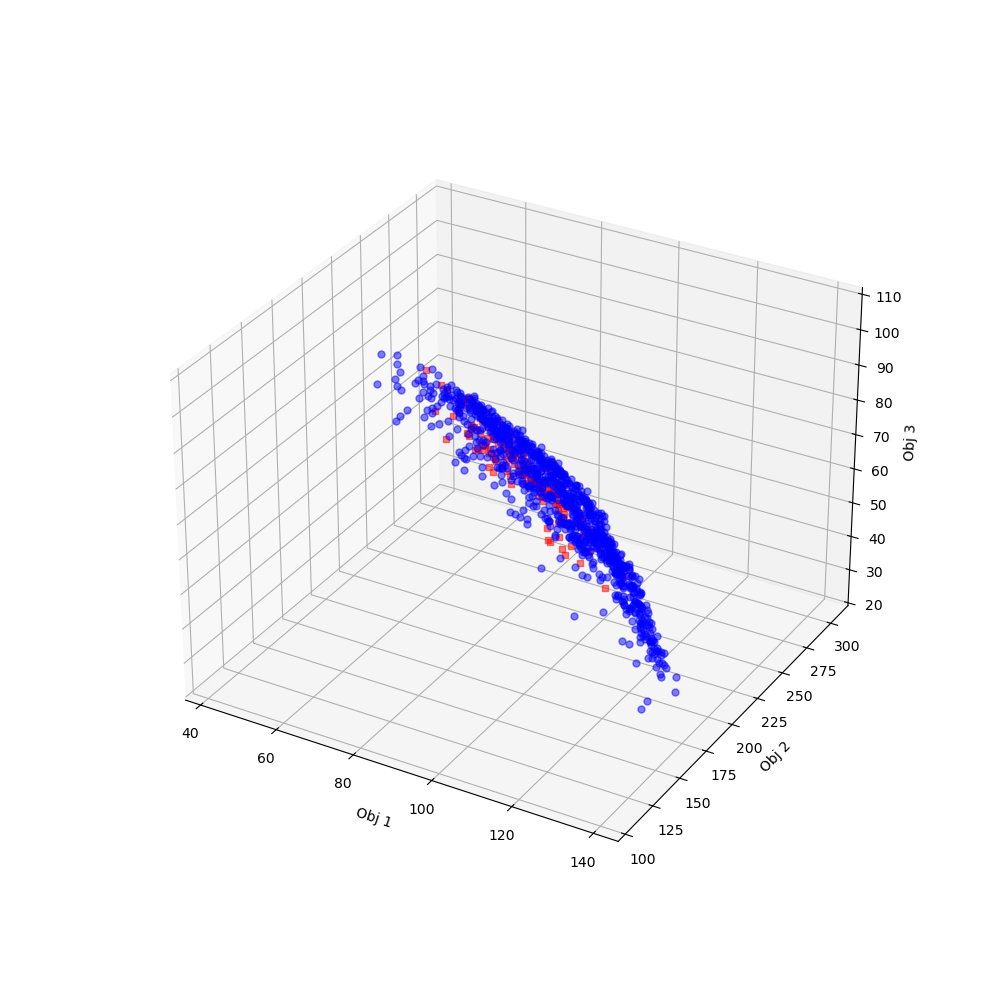

In [37]:
from matplotlib import pyplot as plt
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.plot(pareto_front_softmax[:,0], pareto_front_softmax[:,1], pareto_front_softmax[:,2], 'rs', alpha=0.5, markersize=5)
ax.plot(pareto_front[:,0], pareto_front[:,1], pareto_front[:,2], 'bo', alpha=0.5, markersize=5)
ax.set_xlabel('Obj 1')
ax.set_ylabel('Obj 2')
ax.set_zlabel('Obj 3')
plt.show()

In [33]:
def calculate_dominated(pf_predicted, pf_actual, n_obj):
    dominated = np.zeros(len(pf_predicted))
    for i in range(len(pf_predicted)):
        for j in range(len(pf_actual)):
            if np.all(pf_actual[j, :n_obj] >= pf_predicted[i, :n_obj]) and \
                np.any(pf_actual[j, :n_obj] > pf_predicted[i, :n_obj]):
                dominated[i] = 1
                break
    return dominated, np.sum(dominated), np.sum(dominated)/len(pf_predicted)

In [34]:
dominated, num_dominated, ratio_dominated = calculate_dominated(pareto_front_softmax, pareto_front, n_obj)
print(ratio_dominated)
pareto_front_softmax_dominated = pareto_front_softmax[dominated.astype(bool), :]

0.04597701149425287


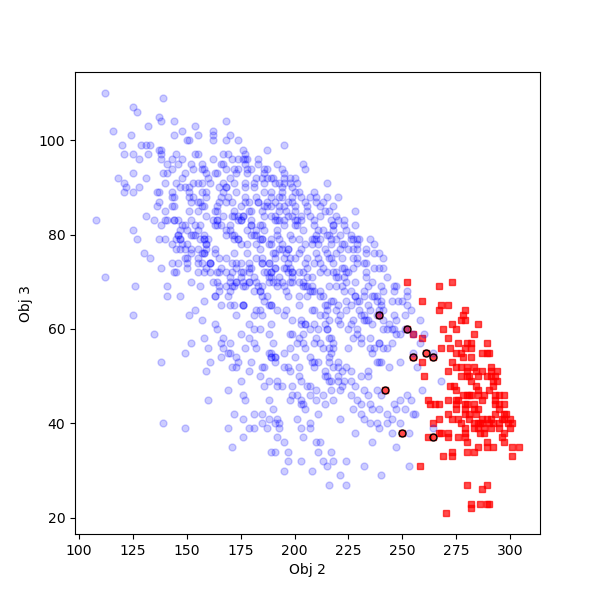

In [35]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()
ax.plot(pareto_front_softmax[:,1], pareto_front_softmax[:,2], 'rs', alpha=0.7, markersize=5)
ax.plot(pareto_front[:,1], pareto_front[:,2], 'bo', alpha=0.2, markersize=5)
ax.plot(pareto_front_softmax_dominated[:,1], pareto_front_softmax_dominated[:,2], marker='o', linestyle='None',
        markerfacecolor='none', markeredgecolor='k', markersize=5)
ax.set_xlabel('Obj 2')
ax.set_ylabel('Obj 3')
plt.show()

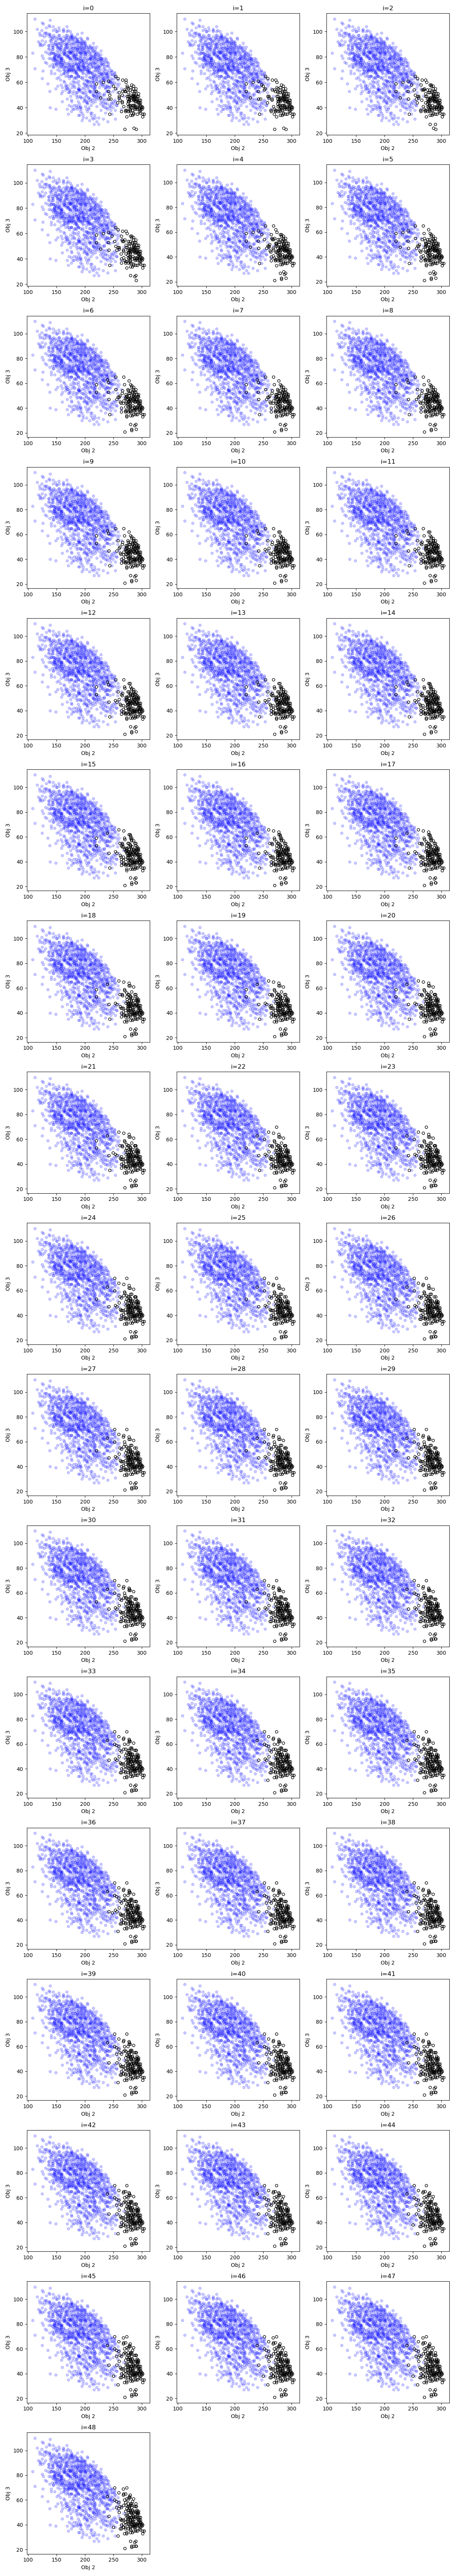

In [36]:
import math
import matplotlib.pyplot as plt

n_plots = len(results['converged_pf_table'])
cols = 3
rows = math.ceil(n_plots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
axes = np.atleast_1d(axes).ravel()

for k, i in enumerate(range(0, len(results['converged_pf_table']))):
    ax = axes[k]

    # ax.plot(pareto_front_softmax[:,1].copy(), pareto_front_softmax[:,2].copy(), 'rs', alpha=0.7, markersize=5)
    ax.plot(pareto_front[:,1].copy(), pareto_front[:,2].copy(), 'bo', alpha=0.2, markersize=5)

    pf = results['converged_pf_table'][i]
    ax.plot(pf[:,1].copy(), pf[:,2].copy(), marker='o', linestyle='None',
        markerfacecolor='none', markeredgecolor='k',
        markersize=5)

    ax.set_title(f"i={i}")
    ax.set_xlabel("Obj 2")
    ax.set_ylabel("Obj 3")

for ax in axes[n_plots:]:
    ax.axis("off")

plt.tight_layout()
plt.show()